This notebook runs the list-learning behavioral analyses

## Import libraries

In [11]:
import quail
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
from scipy.spatial.distance import cdist
%load_ext rpy2.ipython
%matplotlib inline

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Settings and parameters

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
datadir = '/Users/andrewheusser/Documents/cdl/projects/sherlock/data/'
palette = 'bone'

## Load data

In [3]:
video_events = np.load(datadir+'video_event_model.npy')
recall_events = np.load(datadir+'recall_event_models.npy')

## Convert to egg format

In [4]:
pres = [[[{'item' : i, 'topics' : m} for i, m in enumerate(video_events)]] for sub in range(17)]

rec = []
for r in recall_events:
    items = list(np.argmax(1 - cdist(video_events, r), 0).astype(int))
    rec.append([[{'item' : item, 'topics' : t} for item, t in zip(items, r)]])

## Make the egg

In [5]:
egg = quail.Egg(pres=pres, rec=rec)
egg.info()

Number of subjects: 17
Number of lists per subject: 1
Number of words per list: 34
Date created: Mon Aug 20 17:15:12 2018
Meta data: {}


## Run probability of first recall, lagcrp and serial position curve analyses, and create a figure

/Users/andrewheusser/Documents/github/quail_paxton/quail/analysis/recmat.py:103: RuntimeWarning: Mean of empty slice
  return np.nanmean(res, 1)
/Users/andrewheusser/Documents/github/quail_paxton/quail/analysis/lagcrp.py:129: RuntimeWarning: Mean of empty slice
  return np.nanmean(lagcrp, axis=0)


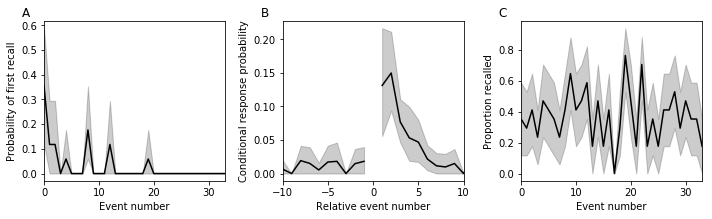

In [7]:
fig, axarr = plt.subplots(1, 3)
fig.set_size_inches(10, 3)

analysis = ['pfr', 'lagcrp', 'spc']
res = {}
for ax, a in zip(axarr, analysis):
    res[a] = egg.analyze(a, match='best', features=['topics'], 
                distance='correlation')
    res[a].plot(show=False, ax=ax, legend=False, palette=palette)
        
# make some adjustments
axarr[1].set_xlim(-10, 10)
axarr[0].set_ylabel('Probability of first recall')
axarr[1].set_ylabel('Conditional response probability')
axarr[2].set_ylabel('Proportion recalled')
axarr[0].set_xlabel('Event number')
axarr[1].set_xlabel('Relative event number')
axarr[2].set_xlabel('Event number')
plt.subplots_adjust(wspace=.45, hspace=.75)
plt.tight_layout()

# add labels
label=['A', 'B', 'C']
for p, l in zip(axarr, label):
    p.text(-.1,1.025,l,
        horizontalalignment='center',
        transform=p.transAxes,
          fontsize=12)
# plt.savefig('../figures/list_learning.pdf')
plt.show()

In [80]:
df = res['pfr'].get_data().melt()
res['pfr'].get_data().melt()
df['subject']=list(range(34))*17
# df.columns = ['position', 'response', 'subject']
df.head()

,variable,value,subject
0,0,0.0,0
1,0,0.0,1
2,0,0.0,2
3,0,1.0,3
4,0,0.0,4


In [81]:
%%R -i df
res = lmer(value ~ variable + (1|subject), family=binomial(link=probit), data=df)
summary(res) 

/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( probit )
Formula: value ~ variable + (1 | subject)
   Data: df
Control: 
structure(list(optimizer = c("bobyqa", "Nelder_Mead"), calc.derivs = TRUE,  
    use.last.params = FALSE, restart_edge = FALSE, boundary.tol = 1e-05,  
    tolPwrss = 1e-07, compDev = TRUE, nAGQ0initStep = TRUE, checkControl = structure(list( 
        check.nobs.vs.rankZ = "ignore", check.nobs.vs.nlev = "stop",  
        check.nlev.gtreq.5 = "ignore", check.nlev.gtr.1 = "stop",  
        check.nobs.vs.nRE = "stop", check.rankX = "message+drop.cols",  
        check.scaleX = "warning", check.formula.LHS = "stop",  
        check.response.not.const = "stop"), .Names = c("check.nobs.vs.rankZ",  
    "check.nobs.vs.nlev", "check.nlev.gtreq.5", "check.nlev.gtr.1",  
    "check.nobs.vs.nRE", "check.rankX", "check.scaleX", "check.formula.LHS",  
    "check.response.not.const")), checkConv = structure(list( 


## Cluster analyses

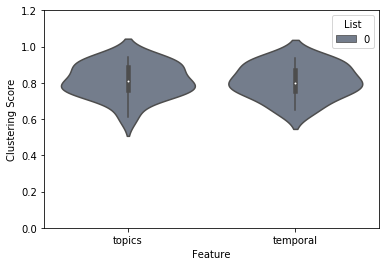

In [55]:
clustering = egg.analyze('fingerprint')
clustering.plot(ylim=[0, 1.2], palette=palette)

## Create a dataframe containing the analysis results

In [47]:
ks = np.array([8, 14, 11, 9, 14, 10, 17, 17, 10, 20, 19, 25, 27, 14, 10, 14, 23])
hand_rec = np.array([27, 24, 32, 33, 32, 39, 30, 39, 28, 40, 34, 38, 47, 38, 27, 37, 39])
auto_rec = res['spc'].data.mean(1).values
df = pd.DataFrame(np.array([clustering.data.temporal.values, clustering.data.topics.values, ks, hand_rec, auto_rec]).T, 
                  columns=['Temporal clustering', 'Semantic clustering', 'Number of events (k)', 'Memory performance - hand', 
                           'Memory performance - auto'])

## Correlation between hand annotated memory and memory estimated from the model across subjects

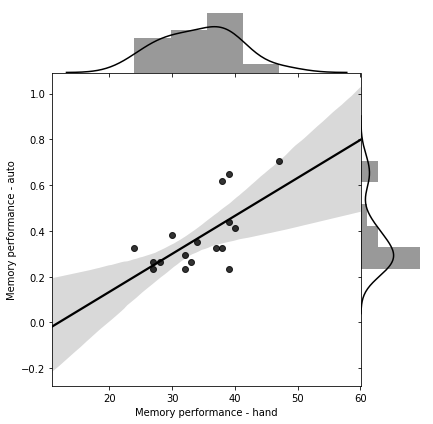

In [50]:
sns.jointplot(x=df['Memory performance - hand'], y=df['Memory performance - auto'], kind='reg', 
              space=False, color='k')

## Correlation between hand annotated memory and k (number of events) across subjects

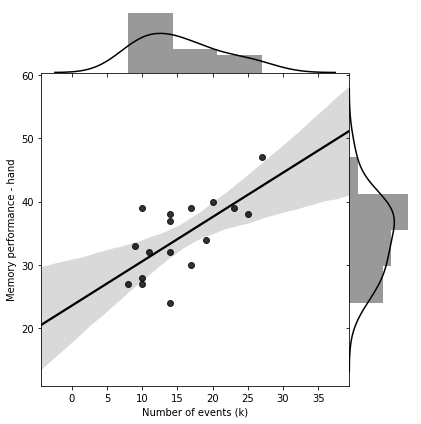

In [51]:
sns.jointplot(y=df['Memory performance - hand'], x=df['Number of events (k)'], kind='reg', space=False, color='k')

## Correlation between hand annotated memory and temporal clustering

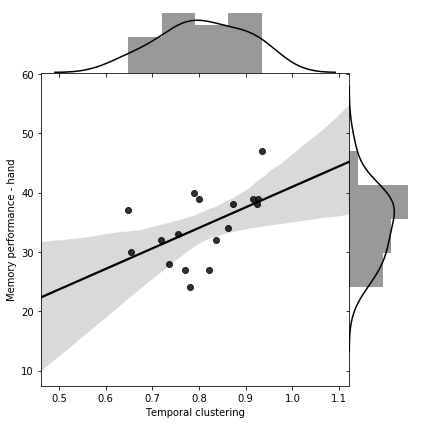

In [52]:
sns.jointplot(y=df['Memory performance - hand'], x=df['Temporal clustering'], kind='reg', space=False, color='k')

## Correlation between hand annotated memory and semantic clustering

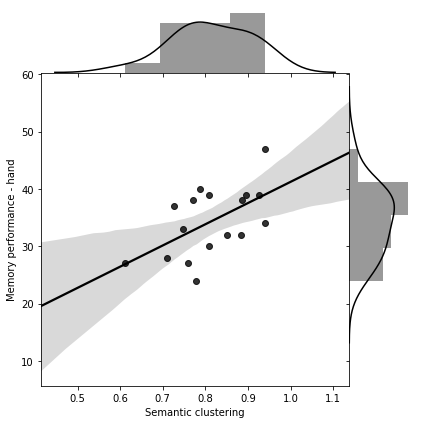

In [53]:
sns.jointplot(y=df['Memory performance - hand'], x=df['Semantic clustering'], kind='reg', space=False, color='k')